# Introduction
## Problem description
“In the United States, over 70 million chest X-rays (CXRs) are performed each year “(1). All those X-rays are interpreted by a radiologist, but the official interpretation may take from hours to days depending on the specific contexts, and there are some clinical centers where there is no radiologist for this interpretation.

It is sometimes necessary to have a quick interpretation and, normally this is done by the medical doctors in the emergency room. Medical doctors are not always confident with their own interpretation so computer aided diagnostic (CAD) could possible help them in the interpretation.

## Objective
In this work we have the objective to use deep learning techniques for a binary class classification. Input will be a frontal (or PA) chest X-ray and the classifier is going to tell us if the exam is normal or not.

## Dataset Description 

NIH Chest X-rays is a dataset containing 108,948 frontalview X-ray images of 32,717 unique patients with the text mined eight disease image labels (where each image can have multi-labels). Label according to the articles are taken from data mining from the PACS.(2)


1. Iyeke L, Moss R, Hall R, Wang J, Sandhu L, Appold B, Kalontar E, Menoudakos D, Ramnarine M, LaVine SP, Ahn S, Richman M. Reducing Unnecessary 'Admission' Chest X-rays: An Initiative to Minimize Low-Value Care. Cureus. 2022 Oct 1;14(10):e29817. doi: 10.7759/cureus.29817. PMID: 36337809; PMCID: PMC9627105.

2. Wang, Xiaosong, and Yifan Peng, et al. (2017) “ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases”, 2017 IEEE Conference on Computer Vision and Pattern Recognition, 10.1109/CVPR.2017.369.

# EDA & Initial data preparations
## Step 1: Imports & data loading

In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # clean output on histograms
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from PIL import Image

In [2]:
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')

print(df.shape)
print(df.info())

(112120, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usa

## Step 2: Limiting population

We have in our hands a very complete dataset without null values. I have to say I am a radiologist with 4 years of experience and as a clinician I think this is low on clinical data. This is not exclusive of this dataset, this is more a problem of every clinical dataset, because of the ethical considerations behind this kind of data.

So, we need to think only in the image classifier and the patient age. As this is going to be a binary class classifier, we are first of all making sure the tag of normal X-rays from adults between 18 and 59 years is correc. So we are now filtering and cheking a random sample. 

In [3]:
df['Finding Labels'].unique

<bound method Series.unique of 0                   Cardiomegaly
1         Cardiomegaly|Emphysema
2          Cardiomegaly|Effusion
3                     No Finding
4                         Hernia
                   ...          
112115            Mass|Pneumonia
112116                No Finding
112117                No Finding
112118                No Finding
112119                No Finding
Name: Finding Labels, Length: 112120, dtype: object>

In [4]:
df.drop(columns=['Unnamed: 11', 'OriginalImagePixelSpacing[x',	'y]', 'OriginalImage[Width', 'Height]' ], inplace=True)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA
3,00000002_000.png,No Finding,0,2,81,M,PA
4,00000003_000.png,Hernia,0,3,81,F,PA


In [5]:
#print(df['Finding Labels'].unique())
#print (df.info())
# df.head()


In [6]:
search_query = "No Finding"
normal_df = df[df['Finding Labels'].str.contains(search_query, case=False, na=False)]
normal_df = normal_df[(normal_df['Patient Age'] >= 18) & (normal_df['Patient Age'] <= 59)]
normal_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44217 entries, 76 to 112119
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Image Index     44217 non-null  object
 1   Finding Labels  44217 non-null  object
 2   Follow-up #     44217 non-null  int64 
 3   Patient ID      44217 non-null  int64 
 4   Patient Age     44217 non-null  int64 
 5   Patient Gender  44217 non-null  object
 6   View Position   44217 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.7+ MB


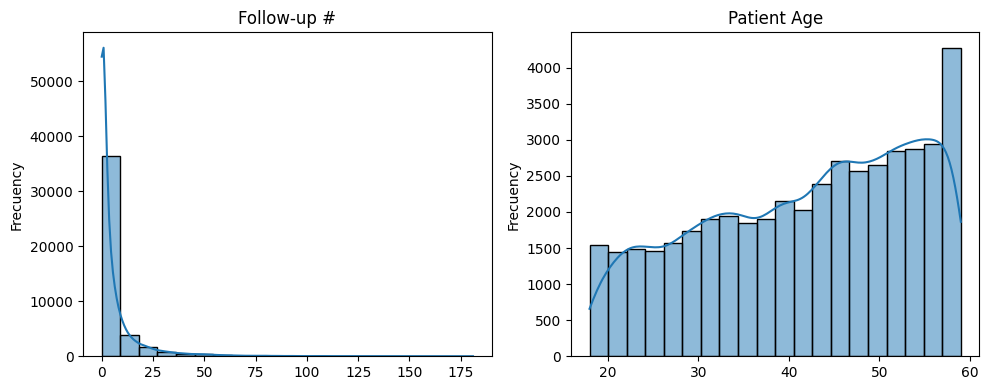

In [7]:
# Plotting numerical columns 
num_cols = ['Follow-up #', 'Patient Age']


# Subplots layout
n_cols = 2  # columns in line
n_rows = (len(num_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.histplot(data=normal_df, x=col, kde=True if df[col].nunique() > 5 else False, bins=20)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Frecuency')

plt.tight_layout()
plt.show()

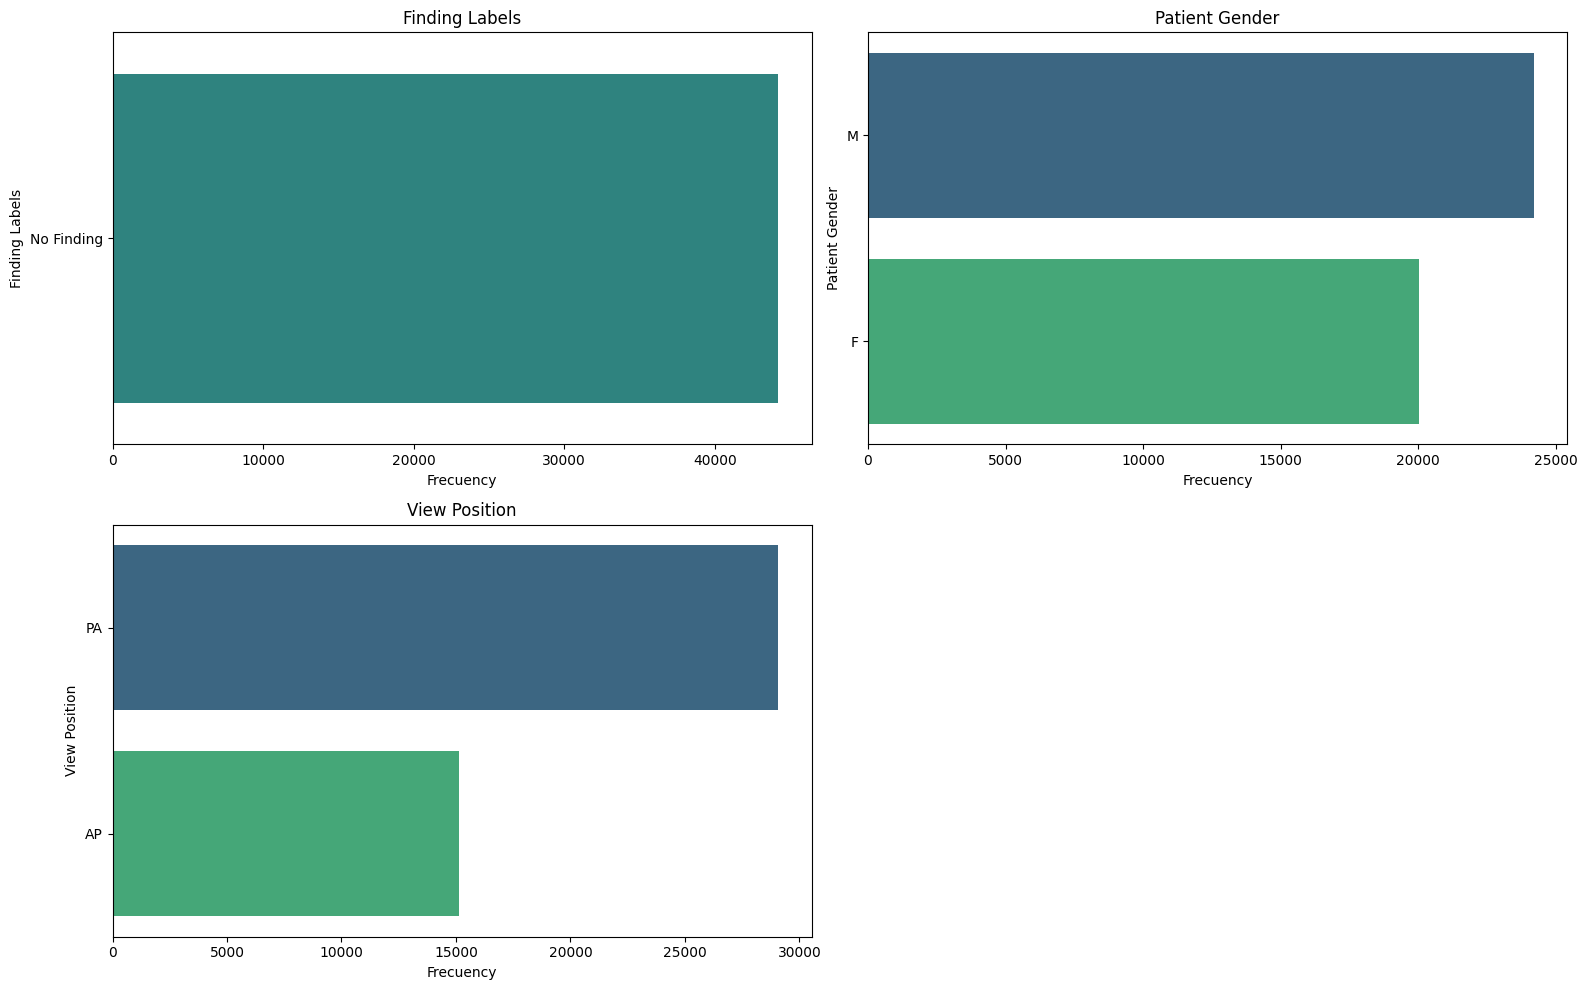

In [8]:
# Categorical columns
cat_cols = normal_df.select_dtypes(include=['object']).columns
cat_cols = [col for col in cat_cols if col not in ['Image Index']]

# layout
n_cols = 2
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 8, n_rows * 5))

for idx, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    
    # Contar los 10 valores más frecuentes
    top_categories = normal_df[col].value_counts().nlargest(10)
    
    sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
    plt.title(col)
    plt.xlabel('Frecuency')

plt.tight_layout()
plt.show()

## Step 3: Looking at some images
In the first cell we are going to asociate the path to the image and check some of them. Lets look at some random sample of 1000 Xrays, tagged as No Findings.

In [ ]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # clean output on histograms
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from PIL import Image

In [ ]:
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
search_query = "No Finding"
normal_df = df[df['Finding Labels'].str.contains(search_query, case=False, na=False)]
normal_df = normal_df[(normal_df['Patient Age'] >= 18) & (normal_df['Patient Age'] <= 59)]
df_sample = normal_df.sample(n=1000, random_state=42).reset_index(drop=True)

In [ ]:
folders = [
    '../input/data/images_001/images',
    '../input/data/images_002/images',
    '../input/data/images_003/images',
    '../input/data/images_004/images',
    '../input/data/images_005/images',
    '../input/data/images_006/images',
    '../input/data/images_007/images',
    '../input/data/images_008/images',
    '../input/data/images_009/images',
    '../input/data/images_010/images',
    '../input/data/images_011/images',
    '../input/data/images_012/images',
]

def find_image_path(filename):
    for folder in folders:
        full_path = os.path.join(folder, filename)
        if os.path.exists(full_path):
            return full_path
    return None

df_sample['image_path'] = df_sample['Image Index'].apply(find_image_path)

"""
CHECK IMG
missing = df_sample[df_sample['image_path'].isnull()]
print(f"Not found: {len(missing)}")

"""

'\nCHECK IMG\nmissing = df_sample[df_sample[\'image_path\'].isnull()]\nprint(f"Not found: {len(missing)}")\n\n'

In [ ]:
paths = df_sample['image_path'].values
all_histograms = []

for path in paths:
    img = Image.open(path).convert('L')  
    img_array = np.array(img)

    hist, _ = np.histogram(img_array, bins=256, range=(0, 255))
    hist = hist / hist.sum()
    all_histograms.append(hist)

# Compute mean histogram
mean_hist = np.mean(all_histograms, axis=0)

# Plot
plt.plot(mean_hist, color='black')
plt.title("Mean Histogram of Grayscale Intensities")
plt.xlabel("Pixel Intensity (0=black, 255=white)")
plt.ylabel("Average Proportion")
plt.grid(True)
plt.show()

# STD
hist_stack = np.stack(all_histograms, axis=0)
std_hist = np.std(hist_stack, axis=0)

# Plot
import matplotlib.pyplot as plt
plt.plot(std_hist, color='red')
plt.title("Standard Deviation of Histogram Bins")
plt.xlabel("Pixel Intensity")
plt.ylabel("Standard Deviation Across Images")
plt.grid(True)
plt.show()


In [ ]:
columns = 2
total = 10
rows = (total + columns - 1) // columns 
random.seed(42)  # Set a constant seed for reproducibility
random_indices = random.sample(range(len(df_sample)), total)

plt.figure(figsize=(columns * 5, rows * 5))

for i, idx in enumerate(random_indices):
    image_path = df_sample.iloc[idx]['image_path']
    pil_img = Image.open(image_path).convert("RGB")
    
    plt.subplot(rows, columns, i + 1)
    plt.imshow(pil_img)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# Main Findings

We have mostly men and PA proyections in a database on tagged "No Findings".

On this random sample one can see this tagged ‘No Finding’ are NOT normal. 
#4 has monitoring elements, No. 1, 2, and number 10 have catheters, No. 5 has bilaterlar opacities and drain cathtetes. This are 4/10 wrongly taged, so I am on trouble. 

If normals are tagged wrong I can’t train this classifier. As those images need to be curated and retagged I am going to tag them manually. I believe this 1000 images are enough.

I will download this database and the csv of the sample look all of them an tag them again.

In [ ]:
"""
import zipfile
from tqdm.notebook import tqdm
import os

# Nombre del archivo zip
zip_filename = 'sampled_images_1000.zip'

# Crear el zip con las 1000 imágenes muestreadas
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for img_path in tqdm(df_sample['image_path'], desc="Empaquetando imágenes"):
        try:
            arcname = os.path.basename(img_path)
            zipf.write(img_path, arcname=arcname)
        except Exception as e:
            print(f"❌ Error al agregar {img_path}: {e}")

print(f"✅ ZIP listo: {zip_filename}")

"""


In [ ]:
df_sample.to_csv('/kaggle/working/df_sample.csv', index=False)
# rm -rf /kaggle/working/

# Final Database
After a manual inspection of the 1000 samples this ended up with 450 normal x ray vs. 550 not normal x ray. The big number of “mislabeled” data is mostly explained by the fact that this database was intended for a different classifier. It has tags on some specific pathologies, and the absence of those diseases is considered “No findings” it does not mean it is normal. Most of the not normal x ray in this sample are because they have catheters, some of them come from people with tracheal tubes and others are clearly mislabeled. But with this curated data I had the fortune to create two separate groups that are almost balanced. <br>
I have here to confess I wanted more x rays, but this manual inspection is time consuming, so for now I will stay with this 1000 sample. I discarted 2 img because they were lateral proyections, and i manually fixed 2 inverted colored img.

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
#Loading dataframe
df = pd.read_csv('/kaggle/input/random-sample-of-adults-nih-normal-chest-x-rays/df_sample.csv')
df.drop(columns=['Finding Labels'], inplace=True)

#variables  for functions
normal_x = set(os.listdir('/kaggle/input/random-sample-of-adults-nih-normal-chest-x-rays/sampled_images_1000/sampled_images_1000'))
not_x = set(os.listdir('/kaggle/input/random-sample-of-adults-nih-normal-chest-x-rays/sampled_images_1000/sampled_images_1000/eliminated'))
folders = [
    '/kaggle/input/random-sample-of-adults-nih-normal-chest-x-rays/sampled_images_1000/sampled_images_1000',
    '/kaggle/input/random-sample-of-adults-nih-normal-chest-x-rays/sampled_images_1000/sampled_images_1000/eliminated'
]

# Funcitions to get labels and paths
def get_label(image_name):
    if image_name in normal_x:
        return 0
    elif image_name in not_x:
        return 1
    else:
        return pd.NaT
        
def find_image_path(filename):
    for folder in folders:
        full_path = os.path.join(folder, filename)
        if os.path.exists(full_path):
            return full_path
    return None  # si no se encontró

# Use functions to get labels and paths
df['label'] = df['Image Index'].apply(get_label)
df['label'].unique()
df['image_path'] = df['Image Index'].apply(find_image_path)


In [ ]:
df = df.dropna()
df.info()

# Modeling
Now we are on track to create our model. Searching on medical database Kufle et al. (1) hay a good performance when using Densenet 121 pretrain (2), which for us comes in handy because we ended up with a small to medium dataset so a pretrain network and transfer learning can help us now.

Also pytorch has a good documentation on how to implement this network. (3, 4)

“Dense Convolutional Network (DenseNet), which connects each layer to every other layer in a feed-forward fashion. Whereas traditional convolutional networks with L layers have L connections - one between each layer and its subsequent layer - our network has L(L+1)/2 direct connections. For each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. DenseNets have several compelling advantages: they alleviate the vanishing-gradient problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters.” (2)


1.	Kufel J, Bielówka M, Rojek M, Mitręga A, Lewandowski P, Cebula M, Krawczyk D, Bielówka M, Kondoł D, Bargieł-Łączek K, Paszkiewicz I, Czogalik Ł, Kaczyńska D, Wocław A, Gruszczyńska K, Nawrat Z. Multi-Label Classification of Chest X-ray Abnormalities Using Transfer Learning Techniques. J Pers Med. 2023 Sep 22;13(10):1426. doi: 10.3390/jpm13101426. PMID: 37888037; PMCID: PMC10607847.
2.	Huang, G., Liu, Z., van der Maaten, L., & Weinberger, K. Q. (2017). Densely Connected Convolutional Networks. Computer Vision and Pattern Recognition, 2261–2269. https://doi.org/10.1109/CVPR.2017.243
3.	https://docs.pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import copy

from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import models
from torch.utils.data import DataLoader

## Step 1: class creation and splitting data
I am not using any data augmentation but chest x-rays are going to need a transformation for they to look as ImageNet data because the network is expecting to have this kind of input.


In [ ]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        #load image
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

In [ ]:
# (224x224px - Normalization -> ImageNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet mean
                         std=[0.229, 0.224, 0.225])    # Imagenet std
])


# 1. Split test-train
df_train, df_val = train_test_split(df, stratify=df["label"], test_size=0.2, random_state=1024)

# 2. Datasets
train_dataset = ChestXrayDataset(df_train, transform=transform) #normal + abnormal
val_dataset = ChestXrayDataset(df_val, transform=transform)
test_dataset = ChestXrayDataset(df.copy(), transform=transform)

# 3. DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
#Print images
classes = ['Normal', 'Not-normal']

def show_image_grid(images, labels, unnormalize=False):
    fig, axes = plt.subplots(2, 8, figsize=(16, 5))
    for i in range(16):
        img = images[i]
        label = labels[i]

        if unnormalize:
            img = img / 2 + 0.5  # unnormalize

        npimg = img.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))  # CHW to HWC

        ax = axes[i // 8, i % 8]
        ax.imshow(npimg)
        ax.set_title(classes[int(label.item())])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show in 8x2 grid
show_image_grid(images, labels, unnormalize=True)  # set to True if needed




## Step 2: Initial configuration of model

In [ ]:
# https://docs.pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DenseNet-121
model = models.densenet121(weights = 'DenseNet121_Weights.IMAGENET1K_V1')

# (classifier) (0 - 1)
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 1),      # 1 output
)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

checkpoint_path = '/kaggle/working/model/'
os.makedirs(checkpoint_path, exist_ok=True)

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, checkpoint_path, val_loader=None):
    model.train()  # Mode
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # shape [B, 1]

        optimizer.zero_grad()          # 1. Clean
        outputs = model(images)        # 2. Forward
        loss = criterion(outputs, labels)  # 3. Loss
        loss.backward()                # 4. Backpropagation
        optimizer.step()               # 5. Weights

        running_loss += loss.item() * images.size(0)  # Total loss

    epoch_loss = running_loss / len(train_loader.dataset)

    # save
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, f"{checkpoint_path}/checkpoint_epoch_{epoch}.pt")
    
    return epoch_loss

## Step 3: def Evaluate 

In [ ]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            preds = (outputs >= 0.5).int()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu().int())

    # all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # FP & FN
    FP = ((all_preds == 1) & (all_labels == 0)).sum().item()
    FN = ((all_preds == 0) & (all_labels == 1)).sum().item()

    avg_loss = val_loss / len(val_loader.dataset)
    
    return avg_loss, FP, FN, all_preds, all_labels



## Step 4: Training

In [ ]:
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, checkpoint_path)
    val_loss, FP, FN, val_preds, val_labels = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss:    {val_loss:.4f}")
    print(f"FP:      {FP}")
    print(f"FN:      {FN}")
    # print(val_preds.numpy().flatten())

# images in validation set: print(val_dataset.df['image_path'].tolist())

# Hyperparameter tuning

Although those are decent results it seems clear this is a hard task. Loss functions tend to go down but the number of mislabeled tend does not go down the same way. Also is evident that after a while the network is overfitting. <br>
Here we try various optimizers and at the same time play with the learning rate to see what is happening. Also, in this problem I believe false negatives are more problematic than false positive. Imagine you are at the ER with pneumonia and the CAD tells your doctor you are okey. I prefer to be okey and the CAD to be a little dramatic, so in the Loss function we are penalizing those FN harder.

In [ ]:
pos_weight = torch.tensor([2.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def train_model_with_optimizer(optimizer_name, model, train_loader, val_loader, criterion, device, epochs=10):
    model_copy = copy.deepcopy(model)
    
    if optimizer_name == 'adam':
        optimizer = torch.optim.Adam(model_copy.parameters(), lr=1e-5)
    elif optimizer_name == 'adamw':
        optimizer = torch.optim.AdamW(model_copy.parameters(), lr=1e-4, weight_decay=1e-2)
    elif optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(model_copy.parameters(), lr=1e-4, momentum=0.9)
    else:
        raise ValueError(f"Optimizer {optimizer_name} no soportado")
    
    checkpoint_path = f'/kaggle/working/othermodels/{optimizer_name}'
    os.makedirs(checkpoint_path, exist_ok=True)

    for epoch in range(epochs):
        train_loss = train_one_epoch(model_copy, train_loader, criterion, optimizer, device, epoch+1, checkpoint_path, val_loader)
        val_loss, FP, FN, val_preds, y_true = evaluate(model_copy, val_loader, criterion, device)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"🔹 Train Loss: {train_loss:.4f}")
        print(f"🔹 Val Loss:    {val_loss:.4f}")
        print(f"🔸 FP:      {FP}")
        print(f"🔸 FN:      {FN}")
        # preditions:  print(val_preds.numpy().flatten())

    return model_copy


In [ ]:
def plot_roc(y_true, y_scores, label=None):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')
    return roc_auc


In [ ]:
optimizers = ['adam', 'adamw', 'sgd']
models = {}
results = {}

for opt_name in optimizers:
    print(f"\nOptimizer: {opt_name}")
    trained_model = train_model_with_optimizer(opt_name, model, train_loader, val_loader, criterion, device, epochs=10)
    models[opt_name] = trained_model

    _, _, _, y_scores, y_true = evaluate(trained_model, val_loader, criterion, device)
    results[opt_name] = (y_true, y_scores)

In [ ]:
#  ROC curves
from sklearn.metrics import roc_curve, auc, confusion_matrix

plt.figure(figsize=(8,6))
for opt_name, (y_true, y_scores) in results.items():
    plot_roc(y_true, y_scores, label=opt_name)
plt.plot([0,1], [0,1], 'k--')  # línea diagonal para referencia
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadero Positivo")
plt.title("Curvas ROC - Comparación de optimizadores")
plt.legend()
plt.show()

In [ ]:
def print_confusion_matrix(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).int().cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print("Matrix (threshold = {:.2f}):".format(threshold))
    print(cm)

for opt_name, (y_true, y_scores) in results.items():
    print(f"\nOptimizador: {opt_name}")
    print_confusion_matrix(y_true, y_scores, threshold=0.5)

# Results & Discution
We are now going to use our best model and check mistakes by hand.

When comparing the ROC curves, we see they are similar, but taking into account the balance between FN and FP I am going to take the one that I consider the most suited to this problem. Lets see FN.

In [ ]:
# Load 
df_test = df[['image_path', 'label']].copy()
model.to(device)

# Choose checkpoint
checkpoint_path = '/kaggle/working/othermodels/adamw/checkpoint_epoch_8.pt'

# Load checkpoint & eval
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

predicted_classes = []
prediction_scores = []

for _, row in df_test.iterrows():
    img_path = row['image_path']
    
    # Load
    pil_img = Image.open(img_path).convert("RGB")
    input_tensor = transform(pil_img).unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Forward
    output = model(input_tensor)
    prediction = torch.sigmoid(output).item()
    predicted_class = 1 if prediction > 0.5 else 0

    # Save
    predicted_classes.append(predicted_class)
    prediction_scores.append(prediction)

# DataFrame
df_test['predicted_class'] = predicted_classes
df_test['score'] = prediction_scores

"""
Check DF

print(df_test.head())
"""

In [ ]:
df_missed = df_test[df_test['label'] != df_test['predicted_class']]
df_missed.to_csv('/kaggle/working/df_missed.csv', index=False)
df_missed.info()

In [ ]:
df_FN = df_missed[(df_missed['label'] == 1) & (df_missed['predicted_class'] == 0)]
columns = 5
total = len(df_FN)
rows = (total + columns - 1) // columns

plt.figure(figsize=(columns * 3, rows * 3))

for i, image_path in enumerate(df_FN['image_path']):
    pil_img = Image.open(image_path).convert("RGB")

    plt.subplot(rows, columns, i + 1)
    plt.imshow(pil_img)
    plt.axis('off')
    label = int(df_FN.iloc[i]['label']) 
    pred = int(df_FN.iloc[i]['predicted_class']) 
    plt.title(f"True: {label} | Pred: {pred}", fontsize=10)

plt.tight_layout()
plt.show()

# Conclusion and final thoughts
This is not the best classifier. It has a margin for improvement because it got wrong 10% of cases, even more if you consider df_test includes images from training, and I can see some big mistakes here. This is a difficult problem as sometimes normal from not normal is only a subtle difference. For future work I believe we need a bigger dataset, we need to test other types of CNN or create a custom one, we need to confirm my tags with colleagues, we can play a little bit more with the learning rate and the punishment for those FN. <br>
In medical images there is so much to work with labels.
It seems that this network is having trouble detecting those invasive catheters and tubes. Can this be because of the low resolution? Do we need special convolutional filter to capture this? Can we play with contrast to make catheters more visible?<br>
Also we did not play and check with details score given by my network, a better treshold can help with FN.

# How does it classify that way?
To finish this work I am going to see hoy this is deciding using GradCAM. (1)

1.	https://datascientest.com/es/que-es-el-metodo-grad-cam

In [ ]:
!pip install torchcam --quiet

In [ ]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from torchcam.utils import overlay_mask

In [ ]:
# 1. IMG
image_path = "/kaggle/input/random-sample-of-adults-nih-normal-chest-x-rays/sampled_images_1000/sampled_images_1000/eliminated/00000193_003.png"
pil_img = Image.open(image_path).convert("RGB")
plt.imshow(pil_img, cmap='gray')

# 2. transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_tensor = transform(pil_img).unsqueeze(0).to(device)
input_tensor.requires_grad_()  # ¡Importante para GradCAM!

# 3. Eval
model.eval()

# 4. CAM
cam_extractor = GradCAM(model, target_layer="features.denseblock4")

# 5. Forward
output = model(input_tensor)

# 6. Predition
prediction = torch.sigmoid(output).item()
predicted_class = 1 if prediction > 0.5 else 0

print(f"Predicción: {'NOT - Normal' if predicted_class == 1 else 'Normal'} (score: {prediction:.4f})")

# 7. Activación CAM
activation_map = cam_extractor(0, output)

In [ ]:
# Show img + activation
pil_img = Image.open(image_path).convert("RGB")
cam = to_pil_image(activation_map[0].cpu(), mode='F').resize(pil_img.size)
result = overlay_mask(pil_img, cam, alpha=0.6)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(pil_img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title("Grad-CAM Overlay")
plt.axis('off')

plt.show()

In this example is evident to me although the image is well classified tracheal tube is missed so this is another problem to work on.

**This code would have been impossible for me without the help of ChatGPT.**


In [ ]:
# rm -rf /kaggle/working/